In [1]:
# -*- coding: utf-8 -*-
"""lime_shap_temporal_multiplicative_norm_zero.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1bo2skRDMSvymA3hf8q3KupAOBaqUMuij

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import pickle
import numpy as np
import geopandas as gpd
import xarray
import rioxarray
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import sys
# Save Execution Time
import datetime

"""
##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO


# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_images_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_image_sequences_dates.npy")
v_test_normalization_factors_std_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path     = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vottignasco_test_images_dates = np.load(v_test_images_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)


print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))
print(len(vottignasco_test_images_dates))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***"""


# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

"""### ***LIME and SHAP: Temporal***

#### ***Temporal-Superpixels***
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import imageio
#from IPython.display import Image

def get_season(day):
  spring = np.arange(80, 172)
  summer = np.arange(172, 264)
  fall = np.arange(264, 355)

  if day in spring:
    season = 'Spring'
  elif day in summer:
    season = 'Summer'
  elif day in fall:
    season = 'Autumn'
  else:
    season = 'Winter'

  return season

# Mappa le stagioni ai colori
season_colors = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'yellow',
    'Autumn': 'orange'
}

def cluster_seasons(seasons):
    clusters = []
    start_index = 0

    for i in range(1, len(seasons)):
        if seasons[i] != seasons[i - 1]:  # Cambia stagione
            clusters.append((start_index, i - 1, seasons[start_index]))  # Salva il cluster precedente
            start_index = i  # Inizia un nuovo cluster

    # Aggiunge l'ultimo cluster
    clusters.append((start_index, len(seasons) - 1, seasons[start_index]))

    return clusters

def create_temporal_superpixels(nr_instance, data_test_image_dates):
  # Converti le date in pandas datetime
  dates = pd.to_datetime(data_test_image_dates[nr_instance])

  # Estrai i giorni e identifica le stagioni
  tm_days = [date.timetuple().tm_yday for date in dates]
  seasons = [get_season(tm_yday) for tm_yday in tm_days]

  temporal_superpixels = cluster_seasons(seasons)

  return temporal_superpixels

# # Esempio

# nr_instance = 34

# temporal_superpixels = create_temporal_superpixels(nr_instance, vottignasco_test_images_dates)

# for start, end, season in temporal_superpixels:
#     print(f"Cluster {season}: from index {start} to {end}")

"""#### ***Rappresentazioni Interpretabili***"""

# Creazione dei z'

import itertools
import numpy as np

def generate_z_primes(n):
  """Args
      n (int): nr di superpixel considerati
     Return
      np.array: tutte le combinazioni possibili di 0 e 1 di lunghezza n
  """

  # Genera tutte le combinazioni possibili di 0 e 1 di lunghezza n
  z_primes = list(itertools.product([0, 1], repeat=n))
  # Converti le tuple in un array numpy (facoltativo)
  z_primes = np.array(z_primes)
  # Elimino il primo elemeno di tutti 0
  z_primes = z_primes[1:]
  # Elimino ultimo elemeno di tutti 1
  z_primes = z_primes[:-1]
  return z_primes

#zs_primes = generate_z_primes(len(superpixels))
#zs_primes

"""#### ***Neighbours***

##### ***Generazione Maschere Rumore Uniforme (1D)***
"""

# temporal_superpixels

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_masks(superpixels, input_size):
    N = len(superpixels)
    masks = np.empty((N, input_size))

    for i, superpixel in tqdm(enumerate(superpixels), desc='Generating masks'):
        start, end, _ = superpixel
        mask = np.ones(input_size)  # Tutti i pixel a 1
        mask[start:end+1] = 0  # Pixel del cluster a 0
        masks[i] = mask

    return masks

# masks = generate_masks(temporal_superpixels, 104)

# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# for i in range(0,len(masks)):
#   # Creiamo un vettore di calore
#   plt.figure(figsize=(10, 2))
#   sns.heatmap([masks[i]], cmap="gray", cbar=True, cbar_kws={'label': 'Valore'},
#             xticklabels=False, yticklabels=False)
#   plt.title(f"Vettore di Calore della Mask nr {i}")
#   plt.show()

"""##### ***Application Masks***"""

def multiplicative_uniform_noise_onechannel(instance, zs_primes, masks, channel, std_zero_value=-0.6486319166678826):
  """
  param:masks: maschere generate per ogni superpixel
  """
  T = instance.shape[0]

  masked = []

  for z in zs_primes:
    masked_instance = copy.deepcopy(instance)
    for i, z_i in enumerate(z):
      if z_i == 0:
        for t in range(T):
          # Applica la perturbazione solo al canale specificato
          masked_instance[t,:,:,channel] = (
              masked_instance[t,:,:,channel] * masks[i][t] + (1 - masks[i][t]) * std_zero_value)

    masked.append(masked_instance)

  return masked

# nr_instance  = 0
# channel_prec = 0

# instance = copy.deepcopy(vottignasco_test_image[nr_instance])
# zs_primes = generate_z_primes(len(superpixels))


# perturbed_instances = multiplicative_uniform_noise_onechannel(instance, zs_primes, masks, channel_prec)

"""#### ***Prediction with Black-Box***"""

import tensorflow as tf
import numpy as np

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)

"""#### ***Calcolo Weigths del Regressore***

###### ***LIME***
Dove *calculate_D*:
* D è la L2-Distance (Distanza Euclidea)
* x è l'istanza originaria da spiegare
* z è la versione perturbata non interpretabile
"""

def calculate_D(instance, perturbed_istance):
  x = instance.flatten()
  z = perturbed_istance.flatten()

  return np.linalg.norm(x - z)

def calculate_weigths_lime(instance, perturbed_instances, percentile_kernel_width):
  distances = [calculate_D(instance, perturbed_instance) for perturbed_instance in perturbed_instances]
  kernel_width = np.percentile(distances, percentile_kernel_width)
  # Importanza vicini
  weights = np.exp(- (np.array(distances) ** 2) / (kernel_width ** 2))
  return weights

"""##### ***Kernel-SHAP***"""

import math
from scipy.special import binom

def shap_kernel_weight(M, z):
  """
    Calcola il peso del kernel di Kernel SHAP per una data maschera (istanza interpretabile).

    Args:
        M (int): Numero totale di feature.
        z (array): Array contenente un zs_prime.

    Returns:
        float: Valore del kernel di pesatura di z'.
    """

  z_size = np.sum(z)
  #print("Mask size: ", mask_size)
  if z_size == 0 or z_size == M:
    return 0  # Peso nullo in questi casi estremi
  # Coefficiente binomiale: M su subset_size (|z'|)
  # Kernel SHAP weight formula
  weight = (M-1)/(binom(M, z_size)*(z_size*(M-z_size)))
  return weight

def calculate_weigths_shap(M, zs_primes):
  weights = []

  for z in zs_primes:
    w = shap_kernel_weight(M, z)
    weights.append(w)

  weights = np.array(weights)
  return weights

"""#### ***Lime-Spatial: Framework***"""

from sklearn.linear_model import Ridge

def lime_shap(nr_instance, dataset_test_image, dataset_test_OHE, dataset_test_images_dates, channels, models,
              input_size, H_station=390.0, std_zero_value=-0.6486319166678826):

  """
  param:int input_size dimensione temporale dei dati (104 nel nostro caso)
  """

  channel_prec, channel_tmax, channel_min = channels

  instance    = copy.deepcopy(dataset_test_image[nr_instance])  # istanza da spiegare
  x3_instance = copy.deepcopy(dataset_test_OHE[nr_instance])    # One-Hot encode mesi dei frame dell'istanza

  # Creazione Superpixel Temporali
  superpixels = create_temporal_superpixels(nr_instance, dataset_test_images_dates)
  # Rappresentazioni Interpretabili dell'istanza
  zs_primes = generate_z_primes(len(superpixels))
  # Creazione maschere
  masks = generate_masks(superpixels, input_size)
  # Creazione dei vicini
  perturbed_instances = multiplicative_uniform_noise_onechannel(instance, zs_primes, masks, channel_prec, std_zero_value)
  # Predizione istanze perturbate
  preds_masked = ensemble_predict(models, list(perturbed_instances), x3_instance, batch_size=1000)
  # Denormalizzazione rispetto l'output della black-box
  denorm_preds_masked  = [pred_masked * vott_target_test_std + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]

  return superpixels, zs_primes, perturbed_instances, denormalized_H_preds_masked

#### ***Evaluation Metrics***

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

import numpy as np

def sorted_per_importance_superpixels_index_1D(array):
    array = np.array(array)  # Assicura che sia un array numpy
    unique_values = np.unique(array)  # Trova i valori unici

    # Crea un dizionario con i valori come chiavi e liste di indici come valori
    indici_per_valore = {val: [] for val in unique_values}

    # Popola il dizionario con gli indici
    for idx, val in enumerate(array):
        indici_per_valore[val].append(idx)

    # Ordina i valori in ordine decrescente
    valori_ordinati = sorted(indici_per_valore.keys(), reverse=True)

    # Crea la lista finale con gli indici raggruppati per valore
    results = [indici_per_valore[val] for val in valori_ordinati]

    return results

##### ***Insertion***

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def update_instance_with_superpixels(current_instance, original_instance, index_of_superpixels):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param index_of_superpixels: Lista contente gli indici del superpixel considerato
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()

    for t in index_of_superpixels:
      new_current_instance[t, :,:, 0] = original_instance[t, :,:, 0]
    return new_current_instance

def insertion(models, original_instance, x3, sorted_per_importance_all_superpixels_index, initial_blurred_instance, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Istanza originale.
    :param x3: Codifica one-hot per la previsione.
    :param sorted_per_importance_all_superpixels_index: Lista di liste di tutti i superpixel per importanza
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza iniziale blurrata
    insertion_images = [initial_blurred_instance]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(initial_blurred_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for index_of_superpixels in sorted_per_importance_all_superpixels_index:
        I_prime = update_instance_with_superpixels(I_prime, original_instance, index_of_superpixels)
        insertion_images.append(I_prime)

    # Calcolo le predizioni sulle istanze a cui ho aggiunto i pixel in maniera graduale
    new_predictions = ensemble_predict(models, insertion_images, x3)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set). Ignora la prima che è sull'img blurrata originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0])
    print(f"Initial Prediction with Blurred Instance, new prediction: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_pixel_new_predictions = denormalized_H_new_predictions[1:]

    for nr_superpixel, error in enumerate(errors):
      print(f"Inserted SuperPixel: {sorted_per_importance_all_superpixels_index[nr_superpixel]}, new prediction: {only_inserted_pixel_new_predictions[nr_superpixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel inseriti

    # Nuovo asse X: numero di superpixel inseriti (1, 2, ..., 8)
    x = np.arange(0, len(total_errors))  # Da 0 a 8 inclusi
    print(x)

    x_for_auc = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x_for_auc, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, marker='o', linestyle='-', label='Error curve', color='blue')
    # # Pallini blu sui punti della curva
    # plt.scatter(x, total_errors, color='blue', zorder=3)

    # # Area sotto la curva
    # plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

    # # Testo AUC in alto a destra
    # plt.text(x[-1] * 0.95, max(total_errors) * 0.9, f'AUC: {auc:.2f}',
    #      horizontalalignment='right')

    # plt.xlabel('Number of superpixels inserted')  # Modifica etichetta asse X
    # plt.ylabel('Mean Squared Error')
    # plt.title('Insertion Metric Curve')
    # plt.xticks(x)  # Imposta i tick esattamente sui numeri interi (1, 2, ..., 8)
    # plt.legend()
    # #plt.grid(True, linestyle='--', alpha=0.6)  # Griglia più leggibile
    # plt.show()
    return total_errors,auc

##### ***Deletion***

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def update_instance_removing_superpixels(current_instance, index_of_superpixels, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param index_of_superpixels: Lista contente gli indici del superpixel considerato
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()

    for t in index_of_superpixels:
      new_current_instance[t,...,0] = std_zero_value
    return new_current_instance

def deletion(models, original_instance, x3_instance, sorted_per_importance_all_superpixels_index, original_prediction, H_station=390.0):
    """
    Calcola la metrica di deletion per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Istanza originale.
    :param x3_instance: Codifica one-hot per la previsione.
    :param sorted_per_importance_all_superpixels_index: Lista di liste di tutti i superpixel per importanza
    :param original_prediction: Predizione originale.
    :return: Lista degli errori ad ogni passo di deletion.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza originale
    deletion_images = []

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(original_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for index_of_superpixels in sorted_per_importance_all_superpixels_index:
        I_prime = update_instance_removing_superpixels(I_prime, index_of_superpixels)
        deletion_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui ho rimosso gradualmente i pixel
    new_predictions = ensemble_predict(models, deletion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original instance, prediction: {original_prediction}, error: {initial_error}")

    for nr_superpixel, error in enumerate(errors):
      print(f"Removed SuperPixel: {sorted_per_importance_all_superpixels_index[nr_superpixel]}, new prediction: {denormalized_H_new_predictions[nr_superpixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel rimossi

    # Plot
    # Nuovo asse X: numero di superpixel inseriti (1, 2, ..., 8)
    x = np.arange(0, len(total_errors))  # Da 0 a 8 inclusi
    #print(x)
    x_for_auc = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x_for_auc, total_errors)
    print(f"Area under the curve (AUC): {auc}")

    # # Plot della curva dell'errore e area sotto la curva (AUC)
    # plt.plot(x, total_errors, marker='o', linestyle='-', label='Error curve', color='blue')
    # # Pallini rossi sui punti della curva
    # plt.scatter(x, total_errors, color='red', zorder=3)
    # # Area sotto la curva
    # plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)

    # # Posiziona il testo AUC alla destra del titolo
    # plt.text(1.02, 1.02, f'AUC: {auc:.2f}',
    #      horizontalalignment='left',
    #      transform=plt.gca().transAxes,  # Coordinate rispetto all'asse (da 0 a 1)
    #      fontsize=11)

    # plt.xlabel('Number of superpixels removed')  # Modifica etichetta asse X
    # plt.ylabel('Mean Squared Error')
    # plt.title('Deletion Metric Curve')
    # plt.xticks(x)  # Imposta i tick esattamente sui numeri interi (1, 2, ..., 8)
    # plt.legend()
    # #plt.grid(True, linestyle='--', alpha=0.6)  # Griglia più leggibile
    # plt.show()
    return total_errors,auc

def calculate_saliency_map_insertion_deletion_errors_auc(nr_instance, coefficients, temporal_superpixels, models=vott_lstm_models_loaded, 
                                                           H_station=390.0, channel_prec=0, std_zero_value=-0.6486319166678826,input_size=(104,5,8,3),T=104,H=5,W=8):
  instance = copy.deepcopy(vottignasco_test_image[nr_instance])
  x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

  abs_coefficients = np.abs(coefficients)

  input_size = T

  saliency_vector_i     = np.zeros(input_size)
  saliency_vector_i_abs = np.zeros(input_size)
  for i, (start,end,_) in enumerate(temporal_superpixels):
     saliency_vector_i[start:end+1]     = coefficients[i]
     saliency_vector_i_abs[start:end+1] = abs_coefficients[i] 

  # Calcolo Ranking per i valori del Saliency_Vector in abs
  all_superpixels_index = sorted_per_importance_superpixels_index_1D(saliency_vector_i_abs)

  # Insertion
  initial_blurred_instance = copy.deepcopy(instance)
  initial_blurred_instance[..., channel_prec] = std_zero_value
  original_prediction = ensemble_predict(models, instance, x3_instance)
  denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)

  errors_insertion,auc_insertion = insertion(models, instance, x3_instance, all_superpixels_index, initial_blurred_instance, denormalized_H_original_prediction)
  # Deletion
  errors_deletion,auc_deletion  = deletion(models, instance, x3_instance, all_superpixels_index, denormalized_H_original_prediction)

  return saliency_vector_i, errors_insertion,auc_insertion, errors_deletion,auc_deletion

2025-03-08 14:42:21.736699: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 14:42:23.403419: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 14:42:27.533353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 14:42:27.536866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 14:42:28.004410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v3559c86b652084571807a9e36814c4acf2fb78a54.json
105
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f6c5e11b100>, <keras.src.engine.functional.Functional object at 0x7f6c57df6bf0>, <keras.src.engine.functional.Functional object at 0x7f6c57b745b0>, <keras.src.engine.functional.Functional object at 0x7f6c57bd7a30>, <keras.src.engine.functional.Functional object at 0x7f6c57a3e6e0>, <keras.src.engine.functional.Functional object at 0x7f6c57a9db10>, <keras.src.engine.functional.Functional object at 0x7f6c57b22e00>, <keras.src.engine.functional.Functional object at 0x7f6c57adcd60>, <keras.src.engine.functional.Functional object at 0x7f6c579c7040>, <keras.src.engine.functional.Functional object at 0x7f6c57875750>]


In [40]:
from sklearn.linear_model import Ridge
import pickle
import numpy as np

# Canali
channel_prec, channel_tmax, channel_tmin = 0, 1, 2
channels = [channel_prec, channel_tmax, channel_tmin]

# Modelli e dimensioni
models = vott_lstm_models_loaded
T, H, W, C = (104, 5, 8, 3)
input_size_temporal = T
std_zero_value = -0.6486319166678826

# Valori alpha e kernel width
alpha_values = [0.1, 10.0]
percentile_kernel_width_values = [50, 90]

# Lunghezza del test set
len_test_set = len(vottignasco_test_image)

# SHAP non ha iperparametri in questo caso (i superpixel temporali sono le stagioni)
# LIME viene valutato con le combinazioni di p per il kernel_width e alpha
# Dizionario per salvare i risultati
results = {"lime": {}, "shap": {}}


##### MOCK PER TESTARLO SOLO SU ISTANZA 0 
instance_0 = copy.deepcopy(vottignasco_test_image[0])
mock_vott_test_image = [instance_0]

len_test_set = len(mock_vott_test_image)

for nr_instance, _ in enumerate(mock_vott_test_image):
  print(f"######################## LIME-SHAP Temporal for instance #{nr_instance} ########################")
  base_start_time_lime_shap = datetime.datetime.now()
  
  superpixels, zs_primes, perturbed_instances, preds_masked = lime_shap(nr_instance, vottignasco_test_image, vottignasco_test_OHE, vottignasco_test_images_dates, channels, models,
                                                                        input_size_temporal)
  
  base_end_time_lime_shap = datetime.datetime.now()
  exec_time_base_lime_shap = base_end_time_lime_shap - base_start_time_lime_shap

  instance = copy.deepcopy(vottignasco_test_image[nr_instance])
  nr_coefficients = len(superpixels)

  # Prepara input per il regressore
  X = np.array([z.flatten() for z in zs_primes])  # Maschere come righe
  y = np.array(preds_masked)  # Predizioni corrispondenti

  ################ SHAP ##############################
  time_start_shap = datetime.datetime.now()

  # SHAP: calcolo dei pesi e regressione
  M = len(superpixels)
  weights_shap = calculate_weigths_shap(M, zs_primes)
  regressor_shap = Ridge(alpha=0.0)
  regressor_shap.fit(X, y, sample_weight=weights_shap)
  coefficients_shap = regressor_shap.coef_

  time_end_shap = datetime.datetime.now()
  exec_time_shap =  (exec_time_base_lime_shap + (time_end_shap - time_start_shap)).total_seconds()

  param_combination_shap = f"no_param_comb_shap"

  #Insertion/Deletion
  saliency_vector_i_shap, errors_insertion_shap,auc_insertion_shap, errors_deletion_shap,auc_deletion_shap =  calculate_saliency_map_insertion_deletion_errors_auc(nr_instance, coefficients_shap, superpixels)

  # Inizializza solo una volta il dizionario per SHAP
  if param_combination_shap not in results["shap"]:
    # Modifica l'inizializzazione dei coefficienti
    results["shap"][param_combination_shap] = {
      "coefficients": [None] * len_test_set,  # Lista per supportare lunghezze variabili
      "saliency_vectors": np.zeros((len_test_set, T)),
      "errors_insertion": len_test_set * [None],
      "auc_insertion": np.zeros((len_test_set, 1)),
      "errors_deletion": len_test_set * [None],
      "auc_deletion": np.zeros((len_test_set, 1)),
      "executions_times": np.zeros((len_test_set, 1)),
      "parameters_comb": param_combination_shap
    } 

  # Salva i coefficienti per ogni istanza
  results["shap"][param_combination_shap]["coefficients"][nr_instance]        = coefficients_shap
  results["shap"][param_combination_shap]["saliency_vectors"][nr_instance, :] = saliency_vector_i_shap
  results["shap"][param_combination_shap]["errors_insertion"][nr_instance]    = errors_insertion_shap
  results["shap"][param_combination_shap]["auc_insertion"][nr_instance, :]    = auc_insertion_shap
  results["shap"][param_combination_shap]["errors_deletion"][nr_instance]     = errors_deletion_shap
  results["shap"][param_combination_shap]["auc_deletion"][nr_instance, :]     = auc_deletion_shap
  results["shap"][param_combination_shap]["executions_times"][nr_instance, :] = exec_time_shap

  ################ END SHAP #####################################

  ################ LIME ######################################### 
  # LIME: ciclo su iperparametri
  for alpha in alpha_values:
    for kernel_width_p in percentile_kernel_width_values:
      time_start_lime = datetime.datetime.now()

      weights_lime = calculate_weigths_lime(instance, perturbed_instances, percentile_kernel_width=kernel_width_p)
      regressor_lime = Ridge(alpha=alpha)
      regressor_lime.fit(X, y, sample_weight=weights_lime)
      coefficients_lime = regressor_lime.coef_

      time_end_lime = datetime.datetime.now()
      exec_time_lime = (exec_time_base_lime_shap + (time_end_lime - time_start_lime)).total_seconds()

      param_combination_lime = f"kw_{kernel_width_p}_alpha_{alpha}"

      # Ranking with Insertion/Deletion
      saliency_vector_i_lime, errors_insertion_lime,auc_insertion_lime, errors_deletion_lime,auc_deletion_lime = calculate_saliency_map_insertion_deletion_errors_auc(nr_instance, coefficients_lime, superpixels)

      if param_combination_lime not in results["lime"]:
        results["lime"][param_combination_lime] = {
          "coefficients": [None] * len_test_set,
          "saliency_vectors": np.zeros((len_test_set, T)),
          "errors_insertion": len_test_set * [None],
          "auc_insertion": np.zeros((len_test_set, 1)),
          "errors_deletion": len_test_set * [None],
          "auc_deletion": np.zeros((len_test_set, 1)),
          "executions_times": np.zeros((len_test_set, 1)),
          "parameters_comb": param_combination_lime
        }

      results["lime"][param_combination_lime]["coefficients"][nr_instance]        = coefficients_lime
      results["lime"][param_combination_lime]["saliency_vectors"][nr_instance, :] = saliency_vector_i_lime
      results["lime"][param_combination_lime]["errors_insertion"][nr_instance]    = errors_insertion_lime
      results["lime"][param_combination_lime]["auc_insertion"][nr_instance, :]    = auc_insertion_lime
      results["lime"][param_combination_lime]["errors_deletion"][nr_instance]     = errors_deletion_lime
      results["lime"][param_combination_lime]["auc_deletion"][nr_instance, :]     = auc_deletion_lime
      results["lime"][param_combination_lime]["executions_times"][nr_instance, :] = exec_time_lime

# Salva risultati una volta per ogni setup
#path_to_save_results = f"/content/lime_shap_temporal_results.pkl"
path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/temporal/results/temporal_results.pkl")
with open(path_to_save_results, 'wb') as f:
  pickle.dump(results, f)

######################## LIME-SHAP Temporal for instance #0 ########################


Generating masks: 9it [00:00, 273.21it/s]


Initial Prediction with Blurred Instance, new prediction: [384.06387], error: 1.8889468908309937
Inserted SuperPixel: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102], new prediction: [385.22253], error: 0.04653889685869217
Inserted SuperPixel: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], new prediction: [385.27417], error: 0.026926517486572266
Inserted SuperPixel: [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], new prediction: [385.28992], error: 0.02200651913881302
Inserted SuperPixel: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], new prediction: [385.3707], error: 0.004565153270959854
Inserted SuperPixel: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], new prediction: [385.38943], error: 0.002384185791015625
Inserted SuperPixel: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], new prediction: [385.44833], error: 0.00010142102837562561
Inserted SuperPixel: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], new prediction: [385.3717], error: 0.00443007890

In [41]:
path_to_load_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/temporal/results/temporal_results.pkl")
# Load della lista results
with open(path_to_load_results, 'rb') as file:
    result_lime_shap = pickle.load(file)

In [42]:
result_lime_shap

{'lime': {'kw_50_alpha_0.1': {'coefficients': [array([-0.00256279,  0.02856937,  0.00244705,  0.04500355,  0.06257021,
            0.0471005 ,  0.00760727,  1.17241812,  0.00842154])],
   'saliency_vectors': array([[-0.00256279, -0.00256279, -0.00256279, -0.00256279, -0.00256279,
           -0.00256279, -0.00256279, -0.00256279, -0.00256279, -0.00256279,
           -0.00256279,  0.02856937,  0.02856937,  0.02856937,  0.02856937,
            0.02856937,  0.02856937,  0.02856937,  0.02856937,  0.02856937,
            0.02856937,  0.02856937,  0.02856937,  0.02856937,  0.00244705,
            0.00244705,  0.00244705,  0.00244705,  0.00244705,  0.00244705,
            0.00244705,  0.00244705,  0.00244705,  0.00244705,  0.00244705,
            0.00244705,  0.00244705,  0.04500355,  0.04500355,  0.04500355,
            0.04500355,  0.04500355,  0.04500355,  0.04500355,  0.04500355,
            0.04500355,  0.04500355,  0.04500355,  0.04500355,  0.04500355,
            0.06257021,  0.06257021

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)

def plot_combined_curves(all_errors_insertion, all_errors_deletion, title="", save_path=""):
    # Creazione della figura e dei due subplot (1 riga, 2 colonne)
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    # Plot per la curva di inserimento
    max_len_insertion = max(map(len, all_errors_insertion))
    padded_array_insertion = np.full((len(all_errors_insertion), max_len_insertion), np.nan)
    for i, row in enumerate(all_errors_insertion):
        padded_array_insertion[i, :len(row)] = row  # Riempie solo le parti esistenti
    #mean_errors_for_insertion_vott = np.nanmean(all_errors_insertion, axis=0)
    mean_errors_for_insertion_vott = np.nanmean(padded_array_insertion, axis=0)

    #x_insertion = np.arange(0, mean_errors_for_insertion_vott.shape[0])
    x_insertion = np.linspace(0, 1, mean_errors_for_insertion_vott.shape[0])
    auc_insertion = calculate_auc(x_insertion, mean_errors_for_insertion_vott)
    auc_text_insertion = f'AUC = {auc_insertion:.2f}'
    axs[0].plot(x_insertion, mean_errors_for_insertion_vott, label=f'Error Curve, {auc_text_insertion}')
    #axs[0].scatter(x_insertion, mean_errors_for_insertion_vott, color='blue', zorder=3)


    axs[0].fill_between(x_insertion, mean_errors_for_insertion_vott, color='skyblue', alpha=0.4)
    axs[0].set_xlabel('Fraction of pixels inserted')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].set_title('Mean Insertion Metric Curve')
    axs[0].legend()

    # Plot per la curva di cancellazione
    max_len_deletion = max(map(len, all_errors_deletion))
    padded_array_deletion = np.full((len(all_errors_deletion), max_len_deletion), np.nan)
    for i, row in enumerate(all_errors_deletion):
        padded_array_deletion[i, :len(row)] = row  # Riempie solo le parti esistenti
    mean_errors_for_deletion_vott = np.nanmean(padded_array_deletion, axis=0)
    #mean_errors_for_deletion_vott = np.nanmean(all_errors_deletion, axis=0)

    #x_deletion = np.arange(0, mean_errors_for_deletion_vott.shape[0])
    x_deletion = np.linspace(0, 1, mean_errors_for_deletion_vott.shape[0])
    auc_deletion = calculate_auc(x_deletion, mean_errors_for_deletion_vott)
    auc_text_deletion = f'AUC = {auc_deletion:.2f}'

    axs[1].plot(x_deletion, mean_errors_for_deletion_vott, label=f'Error Curve, {auc_text_deletion}')
    #axs[1].scatter(x_deletion, mean_errors_for_deletion_vott, color='red', zorder=3)
    axs[1].fill_between(x_deletion, mean_errors_for_deletion_vott, color='lightcoral', alpha=0.4)
    axs[1].set_xlabel('Fraction of pixels removed')
    axs[1].set_ylabel('Mean Squared Error')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].set_title('Deletion Mean Metric Curve')
    axs[1].legend()

    # Aggiungi il titolo globale
    plt.suptitle(title, fontsize=16)
    # Mostra i plot
    plt.tight_layout()

    # Salva la figura con DPI 400
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85)  # Per evitare che il titolo si sovrapponga ai grafici
    #plt.savefig(save_path, dpi=400)

    plt.show()

    return auc_insertion, auc_deletion

In [44]:
errors_insertion_0 = result_lime_shap["lime"]["kw_90_alpha_10.0"]["errors_insertion"]
errors_deletion_0  = result_lime_shap["lime"]["kw_90_alpha_10.0"]["errors_deletion"]
exec_time_0        = result_lime_shap["lime"]["kw_90_alpha_10.0"]["executions_times"]

In [45]:
exec_time_0

array([[15.832078]])

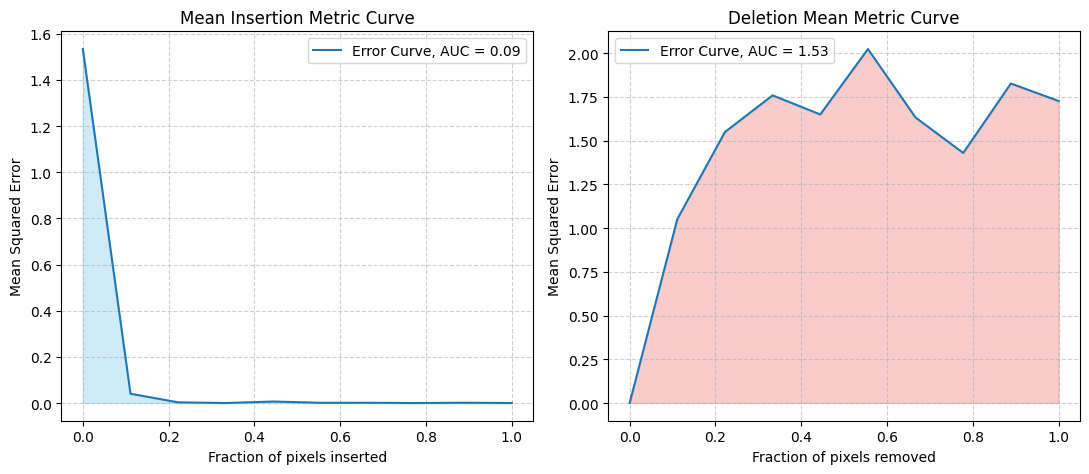

(0.09110742905694576, 1.531082550684611)

In [46]:
plot_combined_curves(errors_insertion_0, errors_deletion_0)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# Funzione per determinare la stagione in base al giorno dell'anno
def get_season(day):
    spring = np.arange(80, 172)
    summer = np.arange(172, 264)
    fall = np.arange(264, 355)

    if day in spring:
        return 'Spring'
    elif day in summer:
        return 'Summer'
    elif day in fall:
        return 'Autumn'
    else:
        return 'Winter'

season_colors = {
    'Winter': '#AEC6CF',  # Azzurro chiaro
    'Spring': '#77DD77',  # Verde menta
    'Summer': '#FFD700',  # Giallo dorato
    'Autumn': '#FF8C00'   # Arancione scuro
}

def plot_saliency_vector(saliency_vector, test_dates, test_images_dates, instance_number, input_size=104):
    dates = pd.to_datetime(test_images_dates[instance_number])
    tm_days = [date.timetuple().tm_yday for date in dates]
    seasons = [get_season(tm_yday) for tm_yday in tm_days]
    colors = [season_colors[season] for season in seasons]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(input_size), saliency_vector, color='black')

    # Evidenzia le stagioni come intervalli
    season_intervals = []
    start = 0
    current_season = seasons[0]

    for j in range(1, input_size):
        if seasons[j] != current_season:
            season_intervals.append((start, j, current_season))
            start = j
            current_season = seasons[j]
    season_intervals.append((start, input_size, current_season))

    max_saliency = max(saliency_vector)
    min_saliency = min(saliency_vector)
    #print(max_saliency, min_saliency)
    text_offset = max_saliency * +0.06  # Aggiunge un po' di spazio sopra il valore massimo

    for start, end, season in season_intervals:
        ax.axvspan(start, end, color=season_colors[season], alpha=0.2)
        ax.text((start + end) / 2, max_saliency + text_offset, season, color=season_colors[season], fontsize=10, ha='center', va='bottom')

    # Seleziona le date a intervalli regolari per i tick dell'asse x
    month_indices = np.linspace(0, input_size - 1, num=12, dtype=int)
    month_labels = [f"{dates[i].strftime('%b')} {dates[i].year}" for i in month_indices]

    ax.set_xticks(month_indices)
    ax.set_xticklabels(month_labels, rotation=45)

    # Linee tratteggiate per separare i time-step
    for i in range(input_size):
        ax.axvline(x=i, color='grey', linestyle='-', alpha=0.1)

    # Impostare i limiti dell'asse y tra il minimo e massimo della saliency
    ax.set_ylim(min_saliency, max_saliency + (max_saliency - min_saliency) * 0.05)  # Padding solo sopra il max

    
    # Impostare i tick dell'asse y automaticamente in base ai valori della saliency
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))  # Genera tick ragionevoli

    ax.set_title(f"Temporal Saliency Vector for Instance #{instance_number}, Target Date: {test_dates[instance_number][0].astype(str).split('T')[0]}\n(Impact of each week on groundwater level prediction)", pad=26)
    #ax.set_xlabel('Time-step')
    ax.set_ylabel('Saliency score (Relevance of each time-step)')

    fig.subplots_adjust(left=0.1, right=0.9)
    fig.tight_layout()
    plt.show()

In [48]:
saliency_vector_0 = result_lime_shap["lime"]["kw_90_alpha_10.0"]["saliency_vectors"]

saliency_vector_0[0]

array([-0.00262434, -0.00262434, -0.00262434, -0.00262434, -0.00262434,
       -0.00262434, -0.00262434, -0.00262434, -0.00262434, -0.00262434,
       -0.00262434,  0.0231088 ,  0.0231088 ,  0.0231088 ,  0.0231088 ,
        0.0231088 ,  0.0231088 ,  0.0231088 ,  0.0231088 ,  0.0231088 ,
        0.0231088 ,  0.0231088 ,  0.0231088 ,  0.0231088 ,  0.00115536,
        0.00115536,  0.00115536,  0.00115536,  0.00115536,  0.00115536,
        0.00115536,  0.00115536,  0.00115536,  0.00115536,  0.00115536,
        0.00115536,  0.00115536,  0.03737877,  0.03737877,  0.03737877,
        0.03737877,  0.03737877,  0.03737877,  0.03737877,  0.03737877,
        0.03737877,  0.03737877,  0.03737877,  0.03737877,  0.03737877,
        0.05507386,  0.05507386,  0.05507386,  0.05507386,  0.05507386,
        0.05507386,  0.05507386,  0.05507386,  0.05507386,  0.05507386,
        0.05507386,  0.05507386,  0.05507386,  0.03954608,  0.03954608,
        0.03954608,  0.03954608,  0.03954608,  0.03954608,  0.03

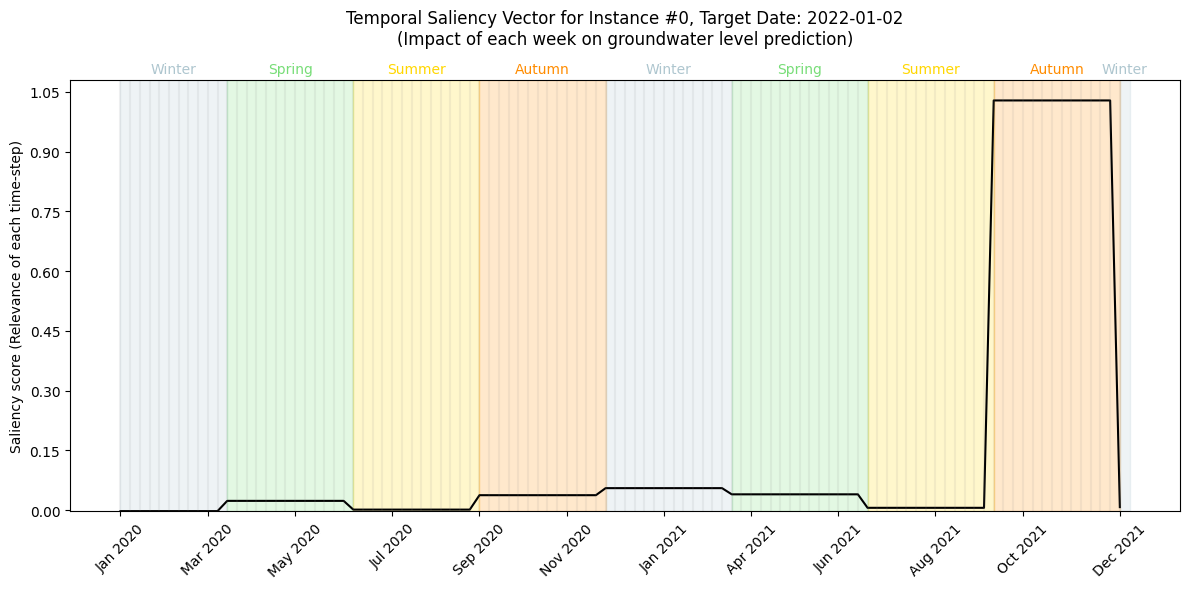

In [49]:
plot_saliency_vector(saliency_vector_0[0], vottignasco_test_dates, vottignasco_test_images_dates, nr_instance)